# Analysis of the effect of starting locations on angular error in HumanA
author: Nora Maleki (noora.maleki@gmail.com)
April 2022

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import statsmodels.formula.api as smf
import researchpy as rp

%matplotlib inline

In [136]:
colorblind_palette = ['#2d004b', '#5ab4ac', '#b2182b', '#8c510a','#4575b4','#8073ac']
sns.set_theme(font_scale=1, palette=colorblind_palette, style='darkgrid')

## Load data

In [137]:
FILE_PATH = r'../../data/01_main'
PLOT_PATH = f'{FILE_PATH}/plots/analysis/'
IMG_PATH = f'{FILE_PATH}/images/'

os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)
os.makedirs(os.path.dirname(IMG_PATH), exist_ok=True)

In [138]:
df_cleaned = pd.read_csv(f'{FILE_PATH}/07_preprocessed.csv')
df_cleaned.head()

,subject_id,body_pos_x,body_pos_z,pointer_pos_x,pointer_pos_z,pointer_dir_x,pointer_dir_z,building_center_z,building_center_x,human_agent,...,dir_to_x_180,target_to_x_360,dir_to_x_360,final_180_angles,final_360_angles,rounded_180_angles,rounded_360_angles,absolute_180_angles,target_building_name,starting_loc_name
0,365,-114.329147,-139.997375,-114.236984,-139.696228,-0.055459,0.989548,53.288437,-72.578285,46,...,93.207763,77.811048,93.207763,15.396716,15.396716,15.0,15.0,15.396716,R (underwater),S (tool shop)
1,365,-65.669235,-159.945099,-65.474716,-159.710205,0.072550,0.992235,53.288437,-72.578285,46,...,85.818077,91.855810,85.818077,-6.037733,353.962267,-6.0,354.0,6.037733,R (underwater),R (motorbike)
2,365,38.849380,53.547638,38.471634,53.516281,-0.993265,-0.112792,53.288437,-72.578285,46,...,-173.521430,180.133280,186.478570,6.345290,6.345290,6.0,6.0,6.345290,R (underwater),R (purpul bat)
3,365,38.880081,53.564148,38.700195,53.581047,-0.995648,-0.065598,53.288437,-72.578285,46,...,-176.230517,180.141730,183.769483,3.627752,3.627752,4.0,4.0,3.627752,R (underwater),R (purpul bat)
4,365,110.754181,196.522675,110.428146,196.550751,-0.941145,-0.321944,53.288437,-72.578285,46,...,-161.115388,217.999848,198.884612,-19.115237,340.884763,-19.0,341.0,19.115237,R (underwater),R (bottle spray)


## Exploring the data

In [139]:
lmm_df = (df_cleaned[['absolute_180_angles', 'RT', 'distance_to_target']]
           .assign(subject_id=df_cleaned.subject_id.astype('category'),
                   starting_loc_id=df_cleaned.starting_loc_id.astype('category'),
                   starting_loc_name=df_cleaned.starting_loc_name.astype('category'),
                   human_agent=df_cleaned.human_agent.astype('category'),
                   trial_id_per_location=df_cleaned.trial_id_per_location.astype('category'),
                   trial_id=df_cleaned.trial_id.astype('category')
                   ))

lmm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7708 entries, 0 to 7707
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   absolute_180_angles    7708 non-null   float64 
 1   RT                     7708 non-null   float64 
 2   distance_to_target     7708 non-null   float64 
 3   subject_id             7708 non-null   category
 4   starting_loc_id        7708 non-null   category
 5   starting_loc_name      7708 non-null   category
 6   human_agent            7708 non-null   category
 7   trial_id_per_location  7708 non-null   category
 8   trial_id               7708 non-null   category
dtypes: category(6), float64(3)
memory usage: 250.3 KB


In [140]:
N = lmm_df.subject_id.nunique()
N

23

In [141]:
rp.codebook(lmm_df)

Variable: absolute_180_angles    Data Type: float64 

 Number of Obs.: 7708 
 Number of missing obs.: 0 
 Percent missing: 0.0 
 Number of unique values: 7708 

 Range: [0.0098611111833122, 179.98338618386344] 
 Mean: 48.08 
 Standard Deviation: 44.3 
 Mode: 0.0098611111833122 
 10th Percentile: 4.061728074435263 
 25th Percentile: 12.864763109725658 
 50th Percentile: 33.697730978897454 
 75th Percentile: 71.5482171723512 
 90th Percentile: 117.0012642321176 





Variable: RT    Data Type: float64 

 Number of Obs.: 7708 
 Number of missing obs.: 0 
 Percent missing: 0.0 
 Number of unique values: 7684 

 Range: [0.955792665481567, 29.289794206619263] 
 Mean: 7.77 
 Standard Deviation: 5.56 
 Mode: 1.3769052028656 
 10th Percentile: 2.431258296966553 
 25th Percentile: 3.621542990207672 
 50th Percentile: 6.063600659370422 
 75th Percentile: 10.153734385967253 
 90th Percentile: 15.809007906913761 





Variable: distance_to_target    Data Type: float64 

 Number of Obs.: 7708 
 Numb

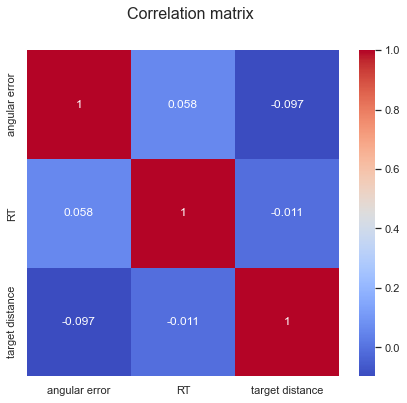

In [142]:
fig, _ = plt.subplots(figsize = (7, 6))

sns.heatmap(
    data=(lmm_df
          .rename(columns={'absolute_180_angles' : 'angular error',
                           'distance_to_target' : 'target distance'})
          .corr()),
    annot = True,
    fmt='.2g',
    cmap= 'coolwarm'
)

plt.suptitle(t='Correlation matrix', size=16, x=.45)

plt.show()

fig.savefig(f'{PLOT_PATH}/correlation_matrix_{N}.png', bbox_inches='tight', dpi=90)

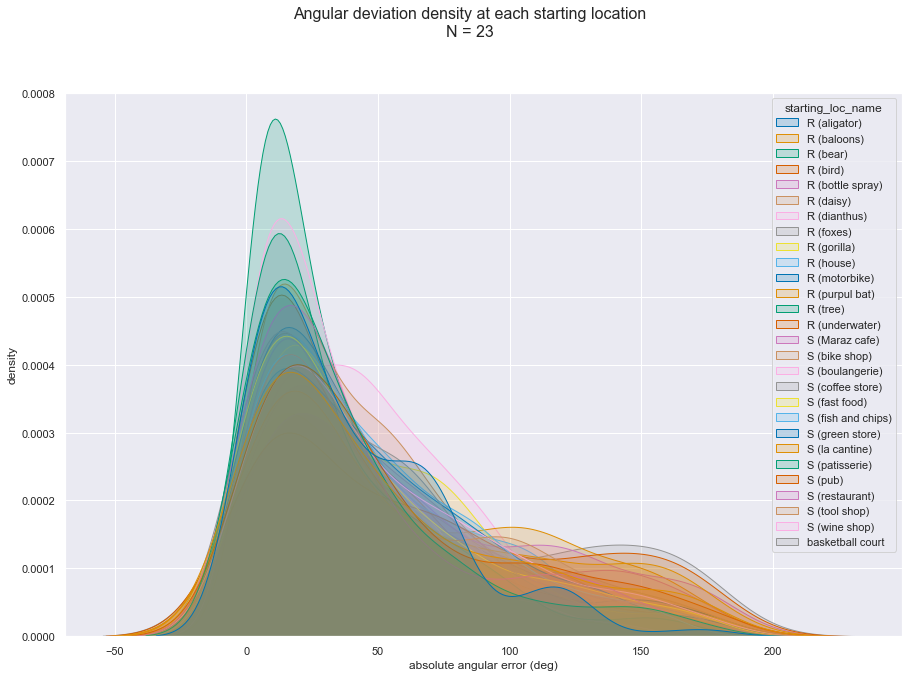

In [143]:
fig, _ = plt.subplots(figsize=(15,10))

sns.kdeplot(
    data=lmm_df,
    x='absolute_180_angles',
    hue='starting_loc_name',
    fill=True,
    palette='colorblind',
    alpha=.2,
).set(xlabel='absolute angular error (deg)', ylabel='density')


plt.suptitle(f'Angular deviation density at each starting location\nN = {N}', size=16, y=1)

fig.savefig(f'{PLOT_PATH}/density_angular_error_per_starting_location_{N}.png', bbox_inches='tight', dpi=90)

plt.show()

In [144]:
mean_median_angle_RT = df_cleaned.groupby(['starting_loc_name', 'starting_loc_id'])[['absolute_180_angles', 'RT']].agg([np.mean, np.median]).reset_index()
mean_median_angle_RT

starting_loc_name starting_loc_id absolute_180_angles             \
                                                      mean     median   
0         R (aligator)              25           39.210534  28.955402   
1          R (baloons)              18           51.974447  35.074110   
2             R (bear)               7           38.726416  25.515426   
3             R (bird)              55           52.320296  37.695538   
4     R (bottle spray)              19           43.025639  28.005307   
5            R (daisy)              43           51.947655  34.293670   
6         R (dianthus)              40           51.191782  37.988246   
7            R (foxes)               1           46.730955  35.664767   
8          R (gorilla)               4           45.796754  29.536517   
9            R (house)              37           47.116459  37.384374   
10       R (motorbike)              36           48.984223  37.948755   
11      R (purpul bat)              30           59.634057  37.568774   
12            R (tree)              54           35.766733  21.200922   
13      R (underwater)              35           65.283762  52.494056   
14      S (Maraz cafe)               5           62.774833  51.251063   
15       S (bike shop)              38           39.224917  31.612215   
16     S (boulangerie)               2           33.525668  23.517914   
17    S (coffee store)              21           45.184079  29.532780   
18       S (fast food)              20           48.065795  35.356497   
19  S (fish and chips)              34           47.018872  35.346270   
20     S (green store)              45           45.285526  30.349194   
21      S (la cantine)              52           60.925282  47.160429   
22      S (patisserie)               9           27.502741  19.176842   
23             S (pub)              14           41.370585  27.834337   
24      S (restaurant)              29           56.852515  41.598931   
25       S (tool shop)              44           45.727937  32.478852   
26       S (wine shop)              51           48.430897  43.256934   
27    basketball court              58           66.847982  49.849104   

          RT            
        mean    median  
0   7.302352  5.570076  
1   8.584581  6.919941  
2   7.737437  6.015261  
3   7.849885  5.603920  
4   6.516070  5.278179  
5   8.664658  6.894657  
6   8.515813  6.350540  
7   7.400864  5.622906  
8   6.688874  5.334976  
9   8.680552  6.694255  
10  7.528648  6.293741  
11  8.479499  6.401871  
12  8.182545  6.274397  
13  9.081363  7.746539  
14  8.556873  7.490835  
15  7.607551  5.647205  
16  7.060426  5.233317  
17  7.421424  5.893713  
18  6.658104  5.803198  
19  8.181344  6.204588  
20  8.205571  6.329449  
21  8.086564  6.553893  
22  7.448431  5.487761  
23  8.277638  6.422948  
24  7.220371  6.004342  
25  7.424411  5.492207  
26  6.694309  4.627191  
27  7.445384  5.829484

In [145]:
mean_median_overall = mean_median_angle_RT.iloc[:,1:].agg([np.mean, np.median])
mean_median_overall

starting_loc_id absolute_180_angles                   RT          
                                      mean     median      mean    median
mean              29.5           48.087405  34.915972  7.767912  6.072192
median            32.0           47.067666  35.210190  7.672494  6.009801

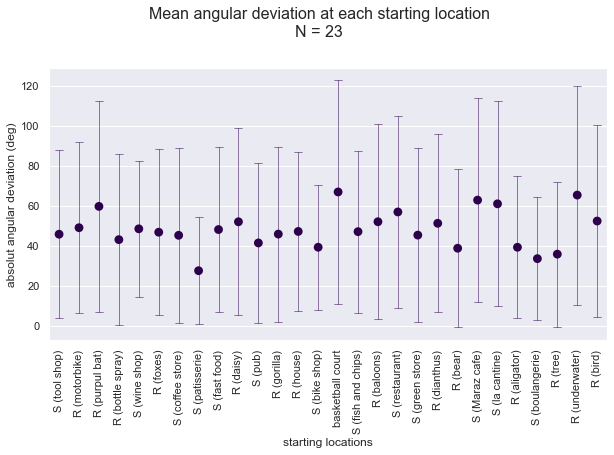

In [146]:
fig, _ = plt.subplots(figsize=(10,5))

sns.pointplot(
    data=df_cleaned,
    x='starting_loc_name',
    y='absolute_180_angles',
    ci='sd',
    join=False,
    errwidth=.5,
    capsize=.4,
).set(xlabel='starting locations', ylabel='absolut angular deviation (deg)')

plt.suptitle(f'Mean angular deviation at each starting location\nN = {N}', size=16, y=1.05)
plt.xticks(rotation=90)
plt.show()

fig.savefig(f'{PLOT_PATH}/mean_angular_deviation_pointplot_{N}.png', bbox_inches='tight', dpi=90)

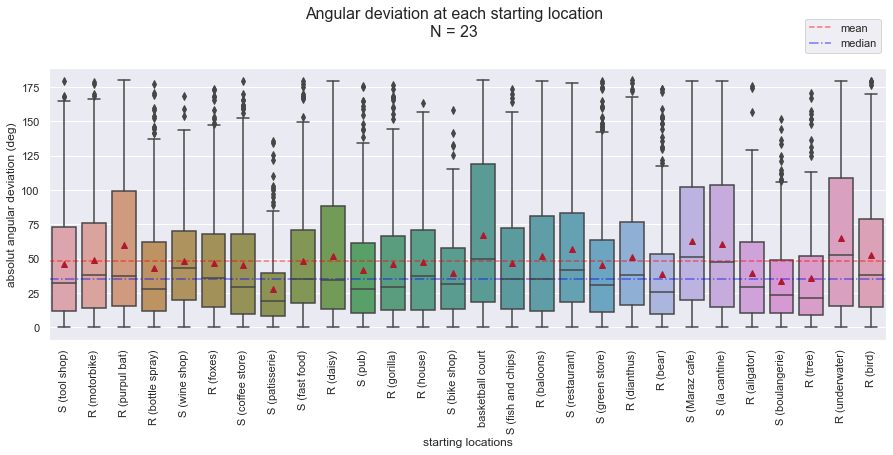

In [147]:
fig, _ = plt.subplots(figsize=(15,5))

sns.boxplot(
    data=df_cleaned,
    x='starting_loc_name',
    y='absolute_180_angles',
    showmeans= True,
    saturation=.5,
).set(xlabel='starting locations', ylabel='absolut angular deviation (deg)')

plt.axhline(y=mean_median_overall.loc['mean', ('absolute_180_angles', 'mean')], alpha=.5, ls='--', c='r', label='mean')
plt.axhline(y=mean_median_overall.loc['median', ('absolute_180_angles', 'median')], alpha=.5, ls='-.', c='b', label='median')

plt.suptitle(f'Angular deviation at each starting location\nN = {N}', size=16, y=1.05)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1.2), loc='upper right')
plt.show()

fig.savefig(f'{PLOT_PATH}/angular_deviation_boxplot_{N}.png', bbox_inches='tight', dpi=90)

In [148]:
lmm_summary = (
    pd.merge(
        rp.summary_cont(lmm_df.groupby(['starting_loc_id'])['absolute_180_angles']),
        lmm_df.groupby(['starting_loc_id', 'starting_loc_name'])['absolute_180_angles'].agg(np.median),
        left_index=True,
        right_index=True,
        how='left')
).rename(columns={'absolute_180_angles': 'Median'}).reset_index()#.sort_values('Median')

lmm_summary

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median
0,1,R (aligator),276,46.731,41.6004,2.5041,41.8014,51.6605,NaN
1,1,R (baloons),276,46.731,41.6004,2.5041,41.8014,51.6605,NaN
2,1,R (bear),276,46.731,41.6004,2.5041,41.8014,51.6605,NaN
3,1,R (bird),276,46.731,41.6004,2.5041,41.8014,51.6605,NaN
4,1,R (bottle spray),276,46.731,41.6004,2.5041,41.8014,51.6605,NaN
...,...,...,...,...,...,...,...,...,...
779,58,S (pub),275,66.848,56.0122,3.3777,60.1985,73.4974,NaN
780,58,S (restaurant),275,66.848,56.0122,3.3777,60.1985,73.4974,NaN
781,58,S (tool shop),275,66.848,56.0122,3.3777,60.1985,73.4974,NaN
782,58,S (wine shop),275,66.848,56.0122,3.3777,60.1985,73.4974,NaN


In [149]:
lmm_summary = (
    (
    pd.merge(
        rp.summary_cont(lmm_df.groupby(['starting_loc_id'])['absolute_180_angles']),
        lmm_df.groupby(['starting_loc_id'])['absolute_180_angles'].agg(np.median),
        left_index=True,
        right_index=True,
        how='left')
).rename(columns={'absolute_180_angles': 'Median'})
        .reset_index()
        .assign(starting_loc_name=lmm_df.starting_loc_id.map(pd.Series(lmm_df.starting_loc_name.values, index=lmm_df.starting_loc_id).to_dict()))
        .sort_values('Median')
)

col_to_move = lmm_summary.pop('starting_loc_name')
lmm_summary.insert(1, 'starting_loc_name', col_to_move)

del col_to_move
lmm_summary

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median
5,9,S (wine shop),276,27.5027,26.7153,1.6081,24.3370,30.6684,19.176842
25,54,S (coffee store),273,35.7667,36.3543,2.2003,31.4350,40.0984,21.200922
1,2,R (motorbike),276,33.5257,30.9483,1.8629,29.8584,37.1930,23.517914
4,7,R (bottle spray),274,38.7264,39.5038,2.3865,34.0281,43.4247,25.515426
6,14,R (foxes),276,41.3706,40.0602,2.4113,36.6236,46.1176,27.834337
8,19,S (patisserie),276,43.0256,42.7547,2.5735,37.9593,48.0920,28.005307
11,25,S (fast food),276,39.2105,35.4404,2.1333,35.0109,43.4101,28.955402
10,21,S (tool shop),274,45.1841,43.9356,2.6542,39.9587,50.4095,29.532780
2,4,R (purpul bat),276,45.7968,43.7805,2.6353,40.6089,50.9846,29.536517
22,45,R (house),275,45.2855,43.6882,2.6345,40.0991,50.4720,30.349194


## Best and worst starting locations based on angular error

### Starting location with the `best` angular performance

In [150]:
s_median = lmm_summary.Median.min()
best_df = lmm_summary.query('Median==@s_median')
ID = best_df.starting_loc_id.values[0]
sl_name = lmm_df.query('starting_loc_id==@ID').starting_loc_name.unique()[0]

display(
    'Best starting location',
    f'name: {sl_name}',
    f'ID: {ID}',
    f'median: {np.round(best_df.Median.values[0], 3)}',
    f'difference to overall median: {np.round(np.abs(np.median(lmm_summary.Median) - best_df.Median.values[0]), 3)}',
    f'overall median: {np.round(np.median(lmm_summary.Median), 3)}',
    f'summary statistics',
    best_df,
)

'Best starting location'

'name: S (patisserie)'

'ID: 9'

'median: 19.177'

'difference to overall median: 16.033'

'overall median: 35.21'

'summary statistics'

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median
5,9,S (wine shop),276,27.5027,26.7153,1.6081,24.337,30.6684,19.176842


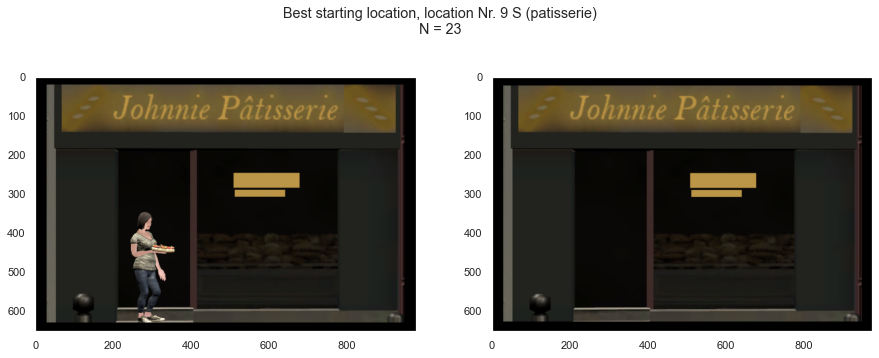

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

img_9_A = mpimg.imread(f'{IMG_PATH}/starting_locations/09_S(patisserie)_A.PNG')
img_9_noA = mpimg.imread(f'{IMG_PATH}/starting_locations/09_S(patisserie)_noA.PNG')

axes[0].imshow(img_9_A)
axes[1].imshow(img_9_noA)

[ax.grid(None) for ax in axes]

plt.suptitle(f'Best starting location, location Nr. 9 S (patisserie)\nN = {N}', y=1.05)

plt.show()

### Starting location with the `worst` angular performance

In [152]:
l_median = lmm_summary.Median.max()
worst_df = lmm_summary.query('Median==@l_median')
ID = worst_df.starting_loc_id.values[0]
sl_name = lmm_df.query('starting_loc_id==@ID').starting_loc_name.unique()[0]

display(
    'Worst starting location',
    f'name: {sl_name}',
    f'ID: {ID}',
    f'median: {np.round(worst_df.Median.values[0], 3)}',
    f'difference to overall median: {np.round(np.abs(np.median(lmm_summary.Median) - worst_df.Median.values[0]), 3)}',
    f'overall median: {np.round(np.median(lmm_summary.Median), 3)}',
    f'summary statistics',
    worst_df,
)

'Worst starting location'

'name: R (underwater)'

'ID: 35'

'median: 52.494'

'difference to overall median: 17.284'

'overall median: 35.21'

'summary statistics'

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median
15,35,S (tool shop),272,65.2838,54.8018,3.3228,58.7419,71.8256,52.494056


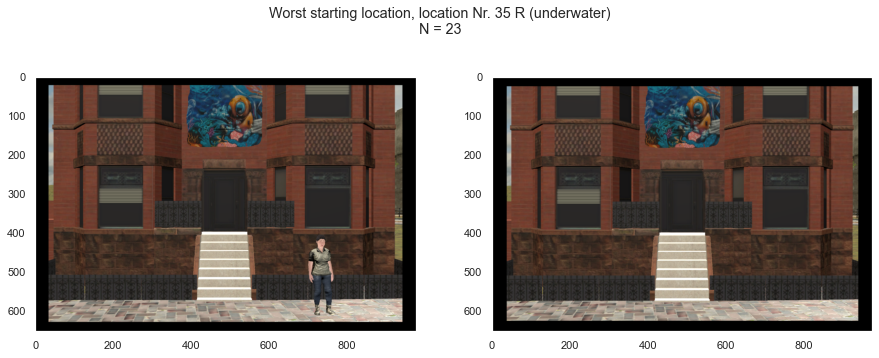

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

img_35_A = mpimg.imread(f'{IMG_PATH}/starting_locations/35_R(underwater)_A.PNG')
img_35_noA = mpimg.imread(f'{IMG_PATH}/starting_locations/35_R(underwater)_noA.PNG')

axes[0].imshow(img_35_A)
axes[1].imshow(img_35_noA)

[ax.grid(None) for ax in axes]
plt.suptitle(f'Worst starting location, location Nr. 35 R (underwater)\nN = {N}', y=1.05)

plt.show()

### Difference between lowest mean error and highest

In [154]:
np.round((worst_df.Median.values[0] - best_df.Median.values[0]), 3)

33.317

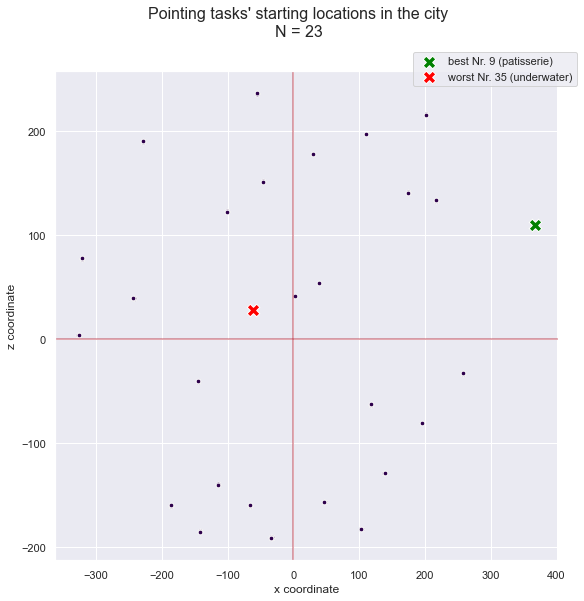

In [130]:
fig, _ = plt.subplots(figsize=(9,9))

best_loc_coord = df_cleaned.query('starting_loc_id == 9')[['starting_loc_x', 'starting_loc_z']].drop_duplicates(keep='first')
worst_loc_coord = df_cleaned.query('starting_loc_id == 35')[['starting_loc_x', 'starting_loc_z']].drop_duplicates(keep='first')

sns.scatterplot(
    data=df_cleaned,
    x='body_pos_x',
    y='body_pos_z',
    s=80,
    marker='.'
).set(xlabel='x coordinate', ylabel='z coordinate')

sns.scatterplot(
    data=best_loc_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    s=160,
    c=['green'],
    marker='X',
    label='best Nr. 9 (patisserie)',
)

sns.scatterplot(
    data=worst_loc_coord,
    x='starting_loc_x',
    y='starting_loc_z',
    s=160,
    c=['red'],
    marker='X',
    label='worst Nr. 35 (underwater)',
)


plt.suptitle(t=f"Pointing tasks' starting locations in the city\nN = {N}", size=16)
plt.axvline(x=0, color=colorblind_palette[2], alpha=.5)
plt.axhline(y=0, color=colorblind_palette[2], alpha=.5)

plt.grid(1)

plt.legend(bbox_to_anchor=(1.05, 1.05))

fig.savefig(f'{PLOT_PATH}/best_worst_starting_locations.png', bbox_inches='tight', dpi=90)

plt.show()

### Results

**Best starting location**: Nr. 9 `(S (patisserie))` with the lowest median `19.177` in angular error.
**Worst starting location**: Nr. 35 `(R (underwater))` with the highest median `52.494` in angular error.

**Degree difference between best and worst starting location**: `33.317` degree

## Choosing a reference starting location for predicting the `absolute angular error`

In [155]:
overall_median = mean_median_overall.loc['median', ('absolute_180_angles', 'median')]
overall_mean = mean_median_overall.loc['mean', ('absolute_180_angles', 'mean')]

display(
    f'mean: {overall_mean}',
    f'median: {overall_median}'
)

'mean: 48.08740511037775'

'median: 35.21019045157068'

In [156]:
diff_df = (lmm_summary
 .query('Median >= 35 & Median < 35.5 ')
 .assign(
    diff_mean=np.abs(overall_mean - lmm_summary.Mean),
    diff_median=np.abs(overall_median - lmm_summary.Median))
           .sort_values('diff_median', ascending=True)
 )

diff_df

,starting_loc_id,starting_loc_name,N,Mean,SD,SE,95% Conf.,Interval,Median,diff_mean,diff_median
7,18,S (coffee store),274,51.9744,48.8015,2.9482,46.1703,57.7786,35.074110,3.886995,0.136080
14,34,R (daisy),275,47.0189,40.5075,2.4427,42.2100,51.8277,35.346270,1.068505,0.136080
9,20,S (patisserie),276,48.0658,41.1517,2.4770,43.1894,52.9422,35.356497,0.021605,0.146307


In [157]:
diff_df.diff_median.values[0] == diff_df.diff_median.values[1]

True

Conclusion:
Median differences of starting location `18` and `34` from the grand median are identical.

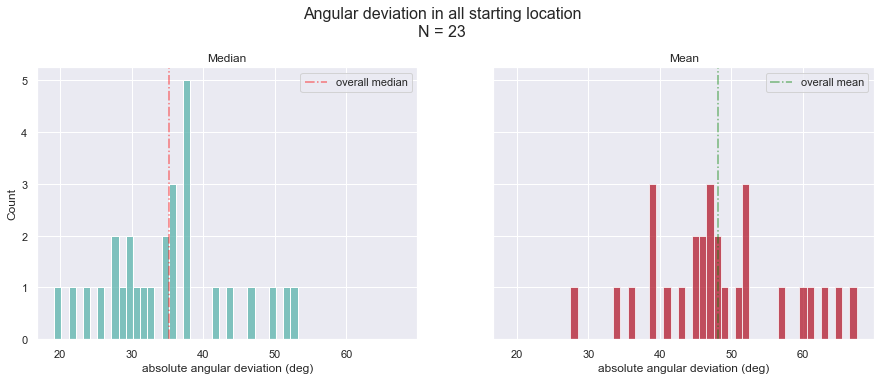

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True, sharey=True)

sns.histplot(
    data=lmm_summary,
    x='Median',
    binwidth=1,
    ax=axes[0],
    color=colorblind_palette[1],
).set(xlabel='absolute angular deviation (deg)', title='Median')

sns.histplot(
    data=lmm_summary,
    x='Mean',
    binwidth=1,
    ax=axes[1],
    color=colorblind_palette[2],
).set(xlabel='absolute angular deviation (deg)', title='Mean')

axes[0].axvline(x=np.median(lmm_summary.Median), alpha=.5, ls='-.', c='r', label='overall median')
axes[1].axvline(x=np.mean(lmm_summary.Mean), alpha=.5, ls='-.', c='g', label='overall mean')

plt.suptitle(f'Angular deviation in all starting location\nN = {N}', size=16, y=1.05)

[ax.legend(loc='upper right') for ax in axes]

plt.show()

fig.savefig(f'{PLOT_PATH}/mean_median_grand_histogram_{N}.png', bbox_inches='tight', dpi=90)

Results:

There are starting locations `34 S(fish and chips)` and `18 R(baloons)` with the least difference to the grand median. Since this is the case, the distance of their means from the grand mean of absolute angular error is also secondarily taken into account for choosing one of them as reference for the analysis.
As a result the starting location `34 S(fish and chips)` is taken to be the reference due to its smaller distance from the grand mean.

## Linear Mixed Models

### Random Intercept model

#### Angular deviation

##### Predicting `angular error` based on `starting location`, `distance to target` and `human agent / building`

Find the starting location id of the location closest to the center of locations
_(this will be used as the reference location for the analysis)_

In [10]:
df_cleaned[df_cleaned.distance_to_center_of_locations == min(df_cleaned.distance_to_center_of_locations)][['starting_loc_id', 'distance_to_center_of_locations']].iloc[0,:]

starting_loc_id                     5.000000
distance_to_center_of_locations    27.763098
Name: 60, dtype: float64

In [14]:
formula = 'absolute_180_angles ~ C(starting_loc_id, Treatment(reference=9))'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                           Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          absolute_180_angles
No. Observations:          7708             Method:                      REML               
No. Groups:                23               Scale:                       1713.9889          
Min. group size:           329              Log-Likelihood:              -39610.1276        
Max. group size:           336              Converged:                   Yes                
Mean group size:           335.1                                                            
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                         27.503    3.717  7.400 0.000 20.218 34.787
C(sta

Results:

In comparison to starting location 5 (the reference point), starting location 52 has the least difference to the results of the angles predicted.

The starting locations 52, 35, 30, 58, 29 do not differ significantly from the reference starting location. All other locations have a significant difference to the reference.


In [48]:
model_LM.random_effects

{365: subject_id    7.81794
 dtype: float64,
 479: subject_id   -22.055755
 dtype: float64,
 1754: subject_id    13.666454
 dtype: float64,
 2258: subject_id   -16.453498
 dtype: float64,
 3246: subject_id   -11.359021
 dtype: float64,
 3572: subject_id    1.32921
 dtype: float64,
 3976: subject_id   -5.66387
 dtype: float64,
 4176: subject_id   -24.392943
 dtype: float64,
 4796: subject_id    10.938194
 dtype: float64,
 5238: subject_id    6.853239
 dtype: float64,
 5531: subject_id    14.245089
 dtype: float64,
 5741: subject_id    10.367571
 dtype: float64,
 6642: subject_id   -13.140607
 dtype: float64,
 7093: subject_id    5.201349
 dtype: float64,
 7264: subject_id    10.535795
 dtype: float64,
 7412: subject_id   -22.674788
 dtype: float64,
 7842: subject_id    6.97044
 dtype: float64,
 8007: subject_id    16.733609
 dtype: float64,
 8469: subject_id   -4.286814
 dtype: float64,
 8695: subject_id   -0.354718
 dtype: float64,
 9472: subject_id    14.075685
 dtype: float64,
 9502:

In [35]:
model_LM.params

Intercept                                            45.234103
C(starting_loc_id, Treatment(reference=10))[T.1]      1.496852
C(starting_loc_id, Treatment(reference=10))[T.2]    -11.708435
C(starting_loc_id, Treatment(reference=10))[T.4]      0.562651
C(starting_loc_id, Treatment(reference=10))[T.5]     17.540730
C(starting_loc_id, Treatment(reference=10))[T.7]     -6.477824
C(starting_loc_id, Treatment(reference=10))[T.9]    -17.731362
C(starting_loc_id, Treatment(reference=10))[T.14]    -3.863518
C(starting_loc_id, Treatment(reference=10))[T.18]     6.764061
C(starting_loc_id, Treatment(reference=10))[T.19]    -2.208465
C(starting_loc_id, Treatment(reference=10))[T.20]     2.831692
C(starting_loc_id, Treatment(reference=10))[T.25]    -6.023569
C(starting_loc_id, Treatment(reference=10))[T.29]    11.618412
C(starting_loc_id, Treatment(reference=10))[T.30]    14.418868
C(starting_loc_id, Treatment(reference=10))[T.34]     1.758498
C(starting_loc_id, Treatment(reference=10))[T.35]    20

In [19]:
formula = 'absolute_180_angles ~ C(starting_loc_id) + distance_to_target + C(trial_id, Treatment(reference=336))'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                          Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         absolute_180_angles
No. Observations:          7708            Method:                     REML               
No. Groups:                23              Scale:                      1708.8779          
Min. group size:           329             Log-Likelihood:             -38401.8516        
Max. group size:           336             Converged:                  Yes                
Mean group size:           335.1                                                          
------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                     52.430    9.502  5.518 0.000  33.807  71.052
C(starting_loc_id)[T.2]   

In [48]:
# icc
0.177 / 1.7067

0.10370891193531376

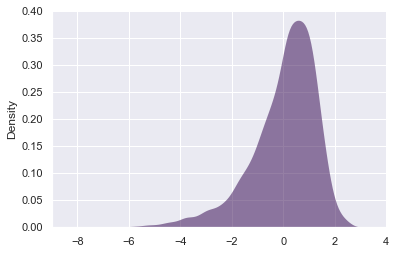

In [49]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

In [50]:
formula = 'np.log(absolute_180_angles) ~ C(starting_loc_id, Treatment(reference=27)) + distance_to_target + C(trial_id_per_location, Treatment(reference=12))'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                              Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         np.log(absolute_180_angles)
No. Observations:          7708            Method:                     REML                       
No. Groups:                23              Scale:                      1.7069                     
Min. group size:           329             Log-Likelihood:             -13092.1128                
Max. group size:           336             Converged:                  Yes                        
Mean group size:           335.1                                                                  
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

In [51]:
# icc
0.177 / 1.7067

0.10370891193531376

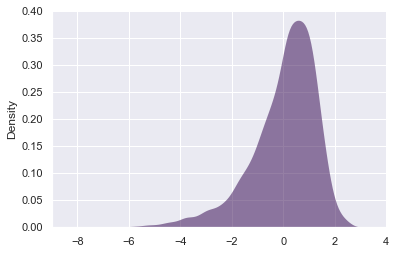

In [52]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

##### Predicting `angular error` based on `starting location` and `distance to target`

In [13]:
formula = 'absolute_180_angles ~ C(starting_loc_id) + distance_to_target + C(trial_id_per_location) + distance_to_target:C(trial_id_per_location)'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                             Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           absolute_180_angles
No. Observations:           7708              Method:                       REML               
No. Groups:                 23                Scale:                        1709.5923          
Min. group size:            329               Log-Likelihood:               -39614.2431        
Max. group size:            336               Converged:                    Yes                
Mean group size:            335.1                                                              
-----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------------------------
Intercept                                          52.253    5.273  9

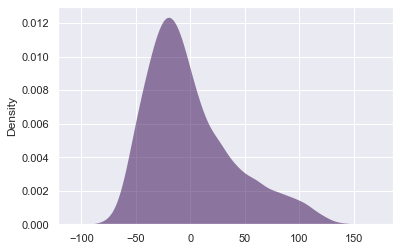

In [14]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

In [55]:
formula = 'np.log(absolute_180_angles) ~ C(starting_loc_id, Treatment(reference=27)) + distance_to_target'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                           Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       np.log(absolute_180_angles)
No. Observations:        7708          Method:                   REML                       
No. Groups:              23            Scale:                    1.7065                     
Min. group size:         329           Log-Likelihood:           -13075.3181                
Max. group size:         336           Converged:                Yes                        
Mean group size:         335.1                                                              
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          3.558    0.121 29.472 0.000  3.321  3.795
C(sta

In [56]:
# icc
0.177 / 1.7065

0.1037210665104014

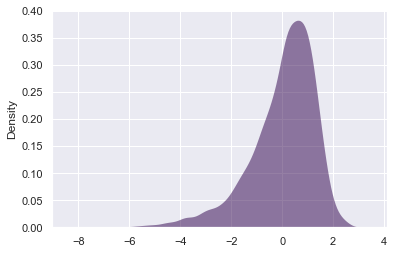

In [57]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

##### Predicting `angular error` based on `starting location`

In [15]:
formula = 'absolute_180_angles ~ C(starting_loc_id)'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  absolute_180_angles
No. Observations:    7708     Method:              REML               
No. Groups:          23       Scale:               1713.9889          
Min. group size:     329      Log-Likelihood:      -39610.1276        
Max. group size:     336      Converged:           Yes                
Mean group size:     335.1                                            
----------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept                 46.731    3.717 12.574 0.000  39.447  54.015
C(starting_loc_id)[T.2]  -13.205    3.524 -3.747 0.000 -20.113  -6.298
C(starting_loc_id)[T.4]   -0.934    3.524 -0.265 0.791  -7.842   5.973
C(starting_loc_id)[T.5]   16.044    3.524  4.552 0.000   9.137  22.951
C(starting_loc_id)[T.7]

In [ ]:
# AIC

In [58]:
# icc
0.177 / 1.7064

0.10372714486638537

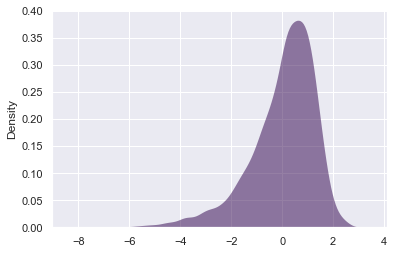

In [59]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

##### Predicting `angular error` based on `distance to target`

In [60]:
formula = 'np.log(absolute_180_angles) ~ distance_to_target'

# Define and fit a linear regression model
model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.log(absolute_180_angles)
No. Observations: 7708    Method:             REML                       
No. Groups:       23      Scale:              1.7466                     
Min. group size:  329     Log-Likelihood:     -13135.9430                
Max. group size:  336     Converged:          Yes                        
Mean group size:  335.1                                                  
---------------------------------------------------------------------------
                       Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------
Intercept               3.324      0.094   35.342   0.000    3.140    3.509
distance_to_target     -0.000      0.000   -2.302   0.021   -0.000   -0.000
subject_id Var          0.176      0.041                                   



In [63]:
# icc
0.176 / 1.7466

0.10076720485514715

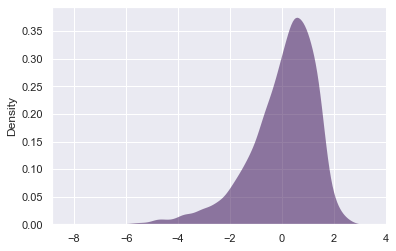

In [62]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

## Random slope model

In [66]:
formula = 'np.log(absolute_180_angles) ~ C(starting_loc_id, Treatment(reference=27)) + C(human_agent)'

# Define and fit a linear regression model
model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id', vc_formula = {'human_agent' : '0 + C(human_agent)'}).fit()
print(model_LM.summary())

                           Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       np.log(absolute_180_angles)
No. Observations:        7708          Method:                   REML                       
No. Groups:              23            Scale:                    1.4526                     
Min. group size:         329           Log-Likelihood:           -12970.9979                
Max. group size:         336           Converged:                Yes                        
Mean group size:         335.1                                                              
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          3.302    0.175 18.850 0.000  2.959  3.646
C(sta